# 3D Uniaxial bar

The objective of this exercise is to implement a 3D finite element analysis (FEA) program using FEniCS. You are required to create a FEniCS code that performs the analysis, solve for the displacements and stresses in the bar, and visualize the results.


Materials:
- Steel material properties:
  - Young's Modulus (E): 200 GPa
  - Poisson's Ratio (ν): 0.3
  - Density (ρ): 7850 kg/m^3

Bar Dimensions:
- Length (Lx): 1 meter
- Ly and Lz: 0.02 meters (20 mm)

Boundary Conditions:
- One end of the bar is fixed (fixed boundary condition).
- The other end is subjected to a uniaxial tensile load:
  - Load (F): 10,000 N

Mesh:
- Use a simple 3D mesh for the bar, consisting of tetrahedral elements.


---
Steps:

1. Import FEniCS and Necessary Libraries
2. Define the Geometry and Mesh
3. Define the Material Properties
4. Define the Boundary Conditions
5. Define the Finite Element Function Space
6. Formulate the Governing Equations.
7.  Solve the System
8.  Calculate Stress
9.  Post-Processing and Visualization:

---

In [1]:
from dolfin import *

In [2]:
Lx, Ly, Lz = 1, 0.02, 0.02

mesh =  BoxMesh(Point(0,0,0), Point(Lx, Ly, Lz), 20,4,4)

In [3]:
mesh

In [4]:
E, nu = 2e11, 0.3
rho, g = 7850, 9.81

lmbda = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

In [5]:
V = FunctionSpace(mesh, 'CG', 1)
U = VectorFunctionSpace(mesh, 'CG', 1)
T0 = TensorFunctionSpace(mesh, 'DG', 0)

In [6]:
dim = mesh.topology().dim()
dim

3

In [7]:
clamped_boundary = CompiledSubDomain("on_boundary && near(x[0],0)")
bc = DirichletBC(U, Constant((0,)*dim), clamped_boundary)

load_boundary = CompiledSubDomain("on_boundary && near(x[0], 1)")

In [8]:
support_tag, load_tag = 1, 2
mf = MeshFunction("size_t", mesh, 2)
mf.set_all(0)
clamped_boundary.mark(mf,support_tag)
load_boundary.mark(mf,load_tag)

In [10]:
ds = Measure("ds", domain=mesh, subdomain_data=mf)

In [11]:
def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)


def sigma(u):
    return lmbda*tr(epsilon(u))*Identity(dim) + 2*mu*epsilon(u)

In [ ]:
u = TrialFunction(U)
v = TestFunction(U)

In [14]:
load = 10000
area = Ly * Lz

T = Constant((load/area, 0, 0))

In [15]:
a = inner(sigma(u), epsilon(v))*dx
L =  dot(t,v)*ds(load_tag)  # dot(f, v)*dx +

In [16]:
# Compute solution
u_sol = Function(U, name="Displacement")
solve(a == L, u_sol, bc)

In [18]:
# Calculate stress
T0 = TensorFunctionSpace(mesh, 'DG', 0)
stress = project(sigma(u_sol), T0)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [20]:
# Calculate von Mises equivalent stress for visualization
# s = sigma - (1/3)*tr(sigma)*I
s = dev(sigma(u_sol))
# von_Mises = sqrt( (3/2) * s:s )
von_Mises = project(sqrt(3.0/2.0 * inner(s, s)), FunctionSpace(mesh, 'DG', 0))
print("Stress calculation complete.")

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Stress calculation complete.


In [21]:
# 9. Post-Processing and Visualization
print("Saving results to files (displacement.pvd, von_mises_stress.pvd)...")
# Save solution in a format that can be read by ParaView or other visualization tools.
# The .pvd file format is a good choice.
File("displacement.pvd") << u_sol
File("von_mises_stress.pvd") << von_Mises

print("\n--- Analysis Finished ---")
print(f"Maximum displacement magnitude: {u_sol.vector().norm('linf'):.4e} meters")
# To find max stress, we look at the values in the projected function's vector
max_stress_val = von_Mises.vector().max()
print(f"Maximum von Mises stress: {max_stress_val/1e6:.2f} MPa")
print("You can now open the .pvd files in ParaView to visualize the 3D results.")

Saving results to files (displacement.pvd, von_mises_stress.pvd)...

--- Analysis Finished ---
Maximum displacement magnitude: 1.2435e-04 meters
Maximum von Mises stress: 25.02 MPa
You can now open the .pvd files in ParaView to visualize the 3D results.


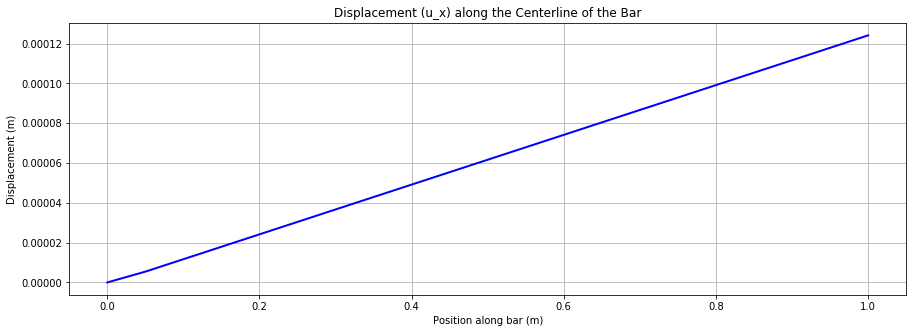

In [23]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15, 5))
# Plot the x-component of displacement along the bar's centerline (y=Ly/2, z=Lz/2)
line_points = [Point(x, Ly/2, Lz/2) for x in np.linspace(0, Lx, 100)]
u_x_values = [u_sol(p)[0] for p in line_points]
x_coords = [p.x() for p in line_points]

plt.plot(x_coords, u_x_values, 'b-', linewidth=2)
plt.title("Displacement (u_x) along the Centerline of the Bar")
plt.xlabel("Position along bar (m)")
plt.ylabel("Displacement (m)")
plt.grid(True)
plt.show()
